# Install some packages

packages installed from within notebook seems to not persist when server shutdown

conda install was too slow solving environment, didn't bother

In [2]:
! pip install spacy
! python -m spacy download en_core_web_sm
! pip install wordcloud

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
!pip install textblob

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Just some imports

nltk download also seems to be cleaned up during server restart

In [4]:
import pandas as pd
import numpy as np
from pathlib import Path
import re
from pprint import pprint
import nltk
from nltk.corpus import words, brown
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import boto3 
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

In [5]:
nltk.download('brown')

[nltk_data] Downloading package brown to /home/ec2-user/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

# All functions are here

Not the best readiblity for notebook, since you have to jump back and forth to read function definitions

But it's the best for clarity and later refactoring/producitonising

In [40]:
def re_find_all_start_positions(regex_pat: str, text: str) -> list:
    matches = list( re.finditer(regex_pat, text, flags=re.MULTILINE) )
    start_positions = [m.start() for m in matches]
    return start_positions
    
def re_split(regex_pat: str, text: str) -> list:
    """Custom regex split solution, re.split() either throw away the delimiter 
    or keep it as separate items, doesn't suit the needs here.
    """
    split_positions = re_find_all_start_positions(regex_pat, text)
    if split_positions[0] > 0:  # add starting position if it's not there
        split_positions = [0] + split_positions
    split_positions = split_positions + [len(text)]  # add end position

    splits = []
    n_splits = len(split_positions) - 1
    for i in range(n_splits):
        splits.append(text[split_positions[i] : split_positions[i+1]])
    
    assert(''.join(splits) == text)
    
    return splits

def strip_scene_header(scene: str) -> str:
    return re.sub(r"^\tHAMLET\n+ACT [A-Z]+\n+SCENE [A-Z]+\t.+\n+", "", scene, flags=re.MULTILINE)

def re_search(pat: str, text: str) -> str:
    """re.search() wrapper
    returns first matching group, with MULTILINE flag
    returns N/A if not found"""
    match = re.search(pat, text, flags=re.MULTILINE)
    if match:
        return match.group(1)
    else:
        return "N/A"

def get_act_name(scene_header: str) -> str:
    return re_search(r"^\tHAMLET\n+(ACT [A-Z]+)(\n+)", scene_header)
    
def get_scene_name(scene_header: str) -> str:
    return re_search(r"(^SCENE [A-Z]+)(?:\t)", scene_header)
    
def get_scene_title(scene_header: str) -> str:
    return re_search(r"(?:^SCENE [A-Z]+\t)(.+$)", scene_header)
    
def get_scenes_df(full_text: str) -> pd.DataFrame:
    scenes = re_split(r"^\tHAMLET\n+ACT [A-Z]+\n+SCENE [A-Z]+\t.+\n+", full_text)
    
    scenes_dict_list = []
    for s in scenes:
        act_name = get_act_name(s)
        scene_name = get_scene_name(s)
        scene_title = get_scene_title(s)
        scene_text = s
        scenes_dict_list.append({'act_name': act_name, 'scene_name': scene_name, 
                                'scene_title': scene_title, 'scene_text': scene_text})
    
    scenes_df = pd.DataFrame(scenes_dict_list)
    assert(''.join(scenes_df.scene_text) == full_text)
    return scenes_df

def get_scene_header(scene: str) -> str:
    return re_search(r"(^\tHAMLET\n+ACT [A-Z]+\n+SCENE [A-Z]+\t.+\n+)", scene)

def split_scene_into_paragraphs(scene_df_row: pd.Series) -> pd.DataFrame:
    scene = scene_df_row.scene_text
    scene_header = get_scene_header(scene)
    
    paragraphs = []    
    if scene_df_row.scene_name == 'N/A':  # cast section at the beginning of the book
        paragraphs.append({'paragraph_type': 'cast', 'paragraph_text': scene})
    else:  # a proper scene
        scene_body = strip_scene_header(scene)
        header_paragraph = {'paragraph_type': 'header', 'paragraph_text': scene_header}
        paragraphs.append(header_paragraph)
        
        re_speech_header = r"(?<=\n\n)[A-Z][A-Za-z ]+\t"
        re_action_paragraph = r"^\s*\[.+$"

        for paragraph_text in re_split(re_speech_header, scene_body):
            if re.match(re_action_paragraph, paragraph_text, flags=re.MULTILINE):
                paragraph_type = 'action'
            else:
                paragraph_type = 'speech'
            paragraph_dict = {'paragraph_type': paragraph_type, 'paragraph_text': paragraph_text}
            paragraphs.append(paragraph_dict)
    
    # convert to dataframe and copy act/scene info from scene dataframe
    paragraphs_df = pd.DataFrame(paragraphs)
    scene_info = scene_df_row.drop('scene_text')
    for col, val in scene_info.iteritems():
        paragraphs_df[col] = val
    
    assert( ''.join(paragraphs_df.paragraph_text) == scene_df_row.scene_text )
    return paragraphs_df

def get_paragraphs_df(scenes_df: pd.DataFrame) -> pd.DataFrame: 
    paragraphs_df = pd.concat([ split_scene_into_paragraphs(row) for i, row in scenes_df.iterrows() ])
    paragraphs_df = paragraphs_df.reset_index(drop=True)  # reset index to [0,1,2,3,....]
    paragraphs_df = paragraphs_df.reset_index().rename(columns={'index': 'paragraph_id'})  # convert index to paragraph_id
    paragraphs_df['characters'] = paragraphs_df.paragraph_text.map(get_characters_in_paragraph)
    return paragraphs_df

def get_characters_in_paragraph(paragraph_text: str) -> list:
    chars = re.findall(r"(?!^SCENE.+)(^[A-Z][A-Za-z ]+)(?:\t)", paragraph_text, flags=re.MULTILINE)
    return chars

def split_paragraph_into_lines(paragraph_df_row: pd.Series) -> pd.DataFrame:
    paragraph_text = paragraph_df_row.paragraph_text
    lines = re_split(r"^.*\n", paragraph_text)
    
    re_empty_line = r"(^[A-Z][A-Za-z ]+\t[\|\s]*$)|(^[\s]*$)"  # also match 'CHARACTER    |' as empty line
    re_character_name = r"^[A-Z][A-Za-z ]+\t"
    re_action_line = r"^\s*\[.*\]\s*$"
    
    lines_dict_list = []
    for line in lines:
        if re.match(re_empty_line, line, flags=re.MULTILINE):
            line_type = 'empty'
        elif paragraph_df_row.paragraph_type == 'cast':
            line_type = 'cast'
        elif paragraph_df_row.paragraph_type == 'header':
            line_type = 'header'
        elif paragraph_df_row.paragraph_type == 'action':
            line_type = 'action'
        elif re.match(re_action_line, line, flags=re.MULTILINE):
            line_type = 'action'
        else:
            line_type = 'speech'
        line_dict = {'line_type': line_type, 'line': line}
        lines_dict_list.append(line_dict)
    lines_df = pd.DataFrame(lines_dict_list)
    # copy paragraph info over except paragraph_text
    paragraph_info = paragraph_df_row.drop('paragraph_text')
    for col, val in paragraph_info.iteritems():
        lines_df[col] = [val] * len(lines_df)  # had to use this special pattern since character column contains list
    
    assert(''.join(lines_df.line) == paragraph_df_row.paragraph_text)
    return lines_df

def get_lines_df(paragraphs_df: pd.DataFrame) -> pd.DataFrame: 
    lines_df = pd.concat([ split_paragraph_into_lines(row) for i, row in paragraphs_df.iterrows() ])
    lines_df = lines_df.reset_index(drop=True)  # reset index to [0,1,2,3,....]
    lines_df = lines_df.reset_index().rename(columns={'index': 'line_id'})  # convert index to line_id
    return lines_df

def spacy_lemmatise(text: str) -> list:
    # tried to lemmatise the tokens to use it with a smaller corpus (nltk's words.words())
    # turned out it's better to simply use a bigger corpus
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    doc = nlp(text)
    lemmas = [token.lemma_.lower() for token in doc if token.is_alpha]
    tokens = [token.text.lower() for token in doc if token.is_alpha]
    context = []
    for i in range(len(tokens)):
        i_start = i-5 if i>=5 else 0
        i_end = i+5 if i<=len(tokens)-5 else len(tokens)
        context.append(' '.join([t for t in tokens[i_start:i_end]]))
    lemma_map = pd.DataFrame({'token': tokens, 'lemma': lemmas, 'context': context}).drop_duplicates()
    return tokens, lemmas, lemma_map

def get_common_english_words(topn: int) -> list:
    return pd.Series([w.lower() for w in brown.words()])\
            [lambda s: s.str.isalpha()]\
            .value_counts().head(topn).index.values.tolist()

def show_word_cloud(text: str):
    wordcloud = WordCloud(width=800, height=400).generate(text)
    fig, ax = plt.subplots(figsize=(15,8))
    _ = plt.imshow(wordcloud, interpolation='bilinear')
    _ = plt.axis("off")
    
def detect_sentiment_batch(texts: list) -> tuple:
    comprehend = boto3.client('comprehend', region_name='ap-southeast-2')
    results = comprehend.batch_detect_sentiment(TextList=texts, LanguageCode='en')
    sentiments = [ r['Sentiment'] for r in results['ResultList'] ]
    positive_scores = [ r['SentimentScore']['Positive'] for r in results['ResultList'] ]
    negative_scores = [ r['SentimentScore']['Negative'] for r in results['ResultList'] ]
    neutral_scores = [ r['SentimentScore']['Neutral'] for r in results['ResultList'] ]
    mixed_scores = [ r['SentimentScore']['Mixed'] for r in results['ResultList'] ]
    return sentiments, positive_scores, negative_scores, neutral_scores, mixed_scores

def batch_sentiment(texts: list) -> list:
    max_batch_size = 25  # Comprehend API batch size limit
    sentiments = []
    for i in range(0, len(texts), max_batch_size):
        batch_texts = texts[i: i + max_batch_size]
        # made it return the individual scores but didn't end up using them
        batch_sentiments, _, _, _, _ = detect_sentiment_batch(batch_texts)
        sentiments = sentiments + batch_sentiments
        print(f'Processed {len(sentiments)} texts')
    return sentiments

def get_textblob_sentiment_pattern(text: str) -> float:
    return TextBlob(text).sentiment.polarity

def get_textblob_sentiment_naivebayes(text: str) -> str:
    blob = TextBlob(text, analyzer=NaiveBayesAnalyzer())
    return blob.sentiment.classification

# Parameters

Thought there would be more but ended up a single one...

Some of the stuff should be paramters though if we want to reuse/productionise like the regex patterns

They were actually in here before I decided to move them into functions for better readability

In [7]:
DATA_FILE = "hamlet.txt"

# "main" routines starts here

## Read file

In [8]:
full_book = open(DATA_FILE).read()

full_book[:300]

'\tHAMLET\n\n\n\tDRAMATIS PERSONAE\n\n\nCLAUDIUS\tking of Denmark. (KING CLAUDIUS:)\n\nHAMLET\tson to the late, and nephew to the present king.\n\nPOLONIUS\tlord chamberlain. (LORD POLONIUS:)\n\nHORATIO\tfriend to Hamlet.\n\nLAERTES\tson to Polonius.\n\nLUCIANUS\tnephew to the king.\n\n\nVOLTIMAND\t|\n\t|\nCORNELIUS\t|\n\t|\nROSENCRAN'

## Convert into Scenes dataframe

Each Scene would be a row, and I decided to do a loss-less split, in a sense that if you simply concatenate all scene_text, you will end up getting the exact document before split. 

This was inspired by spacy's non-destructive tokenisation, I always admired their approach and this is an opportunity to do something similar. 

In [9]:
scenes_df = get_scenes_df(full_book)

scenes_df

,act_name,scene_name,scene_text,scene_title
0,N/A,N/A,\tHAMLET\n\n\n\tDRAMATIS PERSONAE\n\n\nCLAUDIU...,N/A
1,ACT I,SCENE I,\tHAMLET\n\n\nACT I\n\n\n\nSCENE I\tElsinore. ...,Elsinore. A platform before the castle.
2,ACT I,SCENE II,\tHAMLET\n\n\nACT I\n\n\n\nSCENE II\tA room of...,A room of state in the castle.
3,ACT I,SCENE III,\tHAMLET\n\n\nACT I\n\n\n\nSCENE III\tA room i...,A room in Polonius' house.
4,ACT I,SCENE IV,\tHAMLET\n\n\nACT I\n\n\n\nSCENE IV\tThe platf...,The platform.
5,ACT I,SCENE V,\tHAMLET\n\n\nACT I\n\n\n\nSCENE V\tAnother pa...,Another part of the platform.
6,ACT II,SCENE I,\tHAMLET\n\n\nACT II\n\n\n\nSCENE I\tA room in...,A room in POLONIUS' house.
7,ACT II,SCENE II,\tHAMLET\n\n\nACT II\n\n\n\nSCENE II\tA room i...,A room in the castle.
8,ACT III,SCENE I,\tHAMLET\n\n\nACT III\n\n\n\nSCENE I\tA room i...,A room in the castle.
9,ACT III,SCENE II,\tHAMLET\n\n\nACT III\n\n\n\nSCENE II\tA hall ...,A hall in the castle.


## Further split into paragraphs

Again the splits are loss less

In [10]:
paragraphs_df = get_paragraphs_df(scenes_df)

paragraphs_df.head()

,paragraph_id,paragraph_text,paragraph_type,act_name,scene_name,scene_title,characters
0,0,\tHAMLET\n\n\n\tDRAMATIS PERSONAE\n\n\nCLAUDIU...,cast,N/A,N/A,N/A,"[CLAUDIUS, HAMLET, POLONIUS, HORATIO, LAERTES,..."
1,1,\tHAMLET\n\n\nACT I\n\n\n\nSCENE I\tElsinore. ...,header,ACT I,SCENE I,Elsinore. A platform before the castle.,[]
2,2,\t[FRANCISCO at his post. Enter to him BERNARD...,action,ACT I,SCENE I,Elsinore. A platform before the castle.,[]
3,3,BERNARDO\tWho's there?\n\n,speech,ACT I,SCENE I,Elsinore. A platform before the castle.,[BERNARDO]
4,4,"FRANCISCO\tNay, answer me: stand, and unfold y...",speech,ACT I,SCENE I,Elsinore. A platform before the castle.,[FRANCISCO]


## Split into lines

The document eventually became a denormalised data table (OLAP's favourite :) )

Note each line is tagged as header/speech/action/empty etc.

In [11]:
lines_df = get_lines_df(paragraphs_df)

In [12]:
lines_df.iloc[410:420, :]

,line_id,line,line_type,paragraph_id,paragraph_type,act_name,scene_name,scene_title,characters
410,410,"\tTo business with the king, more than the sco...",speech,65,speech,ACT I,SCENE II,A room of state in the castle.,[KING CLAUDIUS]
411,411,\tOf these delated articles allow.\n,speech,65,speech,ACT I,SCENE II,A room of state in the castle.,[KING CLAUDIUS]
412,412,"\tFarewell, and let your haste commend your du...",speech,65,speech,ACT I,SCENE II,A room of state in the castle.,[KING CLAUDIUS]
413,413,\n,empty,65,speech,ACT I,SCENE II,A room of state in the castle.,[KING CLAUDIUS]
414,414,\n,empty,65,speech,ACT I,SCENE II,A room of state in the castle.,[KING CLAUDIUS]
415,415,CORNELIUS\t|\n,empty,66,speech,ACT I,SCENE II,A room of state in the castle.,"[CORNELIUS, VOLTIMAND]"
416,416,\t| In that and all things will we show our d...,speech,66,speech,ACT I,SCENE II,A room of state in the castle.,"[CORNELIUS, VOLTIMAND]"
417,417,VOLTIMAND\t|\n,empty,66,speech,ACT I,SCENE II,A room of state in the castle.,"[CORNELIUS, VOLTIMAND]"
418,418,\n,empty,66,speech,ACT I,SCENE II,A room of state in the castle.,"[CORNELIUS, VOLTIMAND]"
419,419,\n,empty,66,speech,ACT I,SCENE II,A room of state in the castle.,"[CORNELIUS, VOLTIMAND]"


### Verify that it's still a loss-less split end to end


In [13]:
''.join(lines_df.line) == full_book

True

# Get character lines

One of the tricky things was multiple characters may say the same line together, it's taken care of during the paragraph parsing

In [14]:
speech_lines = lines_df[lambda df: df.line_type=='speech'][['characters', 'line', 'line_id']]

character_lines = pd.DataFrame()
for i, line in speech_lines.iterrows():
    for char in line.characters:
        row = line.to_dict()
        row.pop('characters')
        row['character'] = char
        character_lines = character_lines.append(row, ignore_index=True)

In [15]:
character_lines.head()

,character,line,line_id
0,BERNARDO,BERNARDO\tWho's there?\n,89.0
1,FRANCISCO,"FRANCISCO\tNay, answer me: stand, and unfold y...",91.0
2,BERNARDO,BERNARDO\tLong live the king!\n,93.0
3,FRANCISCO,FRANCISCO\tBernardo?\n,95.0
4,BERNARDO,BERNARDO\tHe.\n,97.0


## Number of lines per character

With all the hard work above, this is now very simple. 

This version seems to have fewer lines comparing to the numbers listed on Wikipedia?

In [16]:
character_lines.groupby('character').size().sort_values(ascending=False)

character
HAMLET               1165
KING CLAUDIUS         513
LORD POLONIUS         357
HORATIO               231
OPHELIA               173
LAERTES               153
QUEEN GERTRUDE        140
ROSENCRANTZ            96
Ghost                  95
MARCELLUS              67
First Player           52
GUILDENSTERN           52
First Clown            52
Player King            44
BERNARDO               38
Player Queen           30
Gentleman              24
VOLTIMAND              22
Second Clown           18
REYNALDO               15
Captain                12
FRANCISCO              10
PRINCE FORTINBRAS       8
LUCIANUS                6
Messenger               5
First Sailor            5
Prologue                3
Danes                   3
All                     2
Servant                 1
CORNELIUS               1
dtype: int64

### Get all the non empty lines

In [17]:
non_empty_lines = ''.join(lines_df[lambda df: df.line_type!='empty'].line)

### Use spacy for tokenising

Tried lemmatising, turned out it wasn't necessary with a bigger dictionary

In [18]:
tokens, tokens_lemmatised, lemma_map = spacy_lemmatise(non_empty_lines)

### Get a list of common enligsh words
nltk's Brown corpus was created in 1961, seems to be a good choice for older literature

In [19]:
common_english_words = get_common_english_words(10000)

common_english_words[:10]

['the', 'of', 'and', 'to', 'a', 'in', 'that', 'is', 'was', 'he']

### Get a list of character names

to be excluded in the word cloud

some characters were referred to without titles, hence the added list

In [20]:
char_names = character_lines.character.unique().tolist() + ['CLAUDIUS', 'POLONIUS', 'GERTRUDE', 'FORTINBRAS']
char_names = [c.lower() for c in char_names]

### Here are the unusal tokens (words)

Convert to Series since list comprehension was too slow

In [21]:
tokens_unusual = pd.Series(tokens)\
                [lambda s: ~s.isin(common_english_words + char_names)]  

tokens_unusual.value_counts()

tis             63
hath            54
exit            36
exeunt          34
ay              33
clown           30
doth            25
denmark         22
nay             21
madness         18
hast            14
norway          13
majesty         12
ho              11
revenge         11
oft             11
re              11
villain         11
offence         10
ere             10
foul            10
iv              10
madam           10
pyrrhus          9
twere            9
ha               9
thine            8
dost             8
wherein          8
hither           7
                ..
favours          1
affront          1
earthly          1
slanders         1
purged           1
holla            1
counsellor       1
tempest          1
falsehood        1
appurtenance     1
churchyards      1
swaddling        1
quarrelling      1
tyrannically     1
spendthrift      1
favourite        1
galls            1
stoops           1
personae         1
inheritance      1
hugger           1
befitted    

## Unusual word cloud

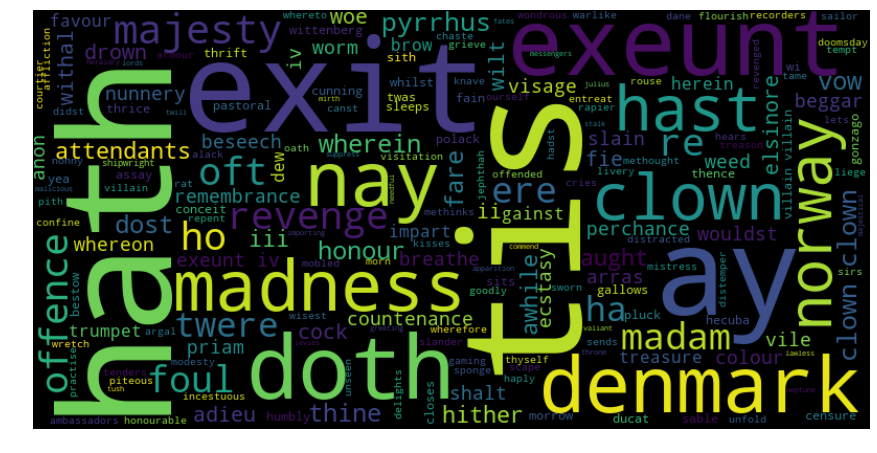

In [22]:
show_word_cloud(' '.join(tokens_unusual))

# Get sentiments using AWS Comprehend

Using a top-tier paid NLP API seems cheating, but realistically the next best free option is probably fine-tuning BERT with a public dataset. But tuning BERT itself is costly and a good public sentiment dataset is hard to find (especially for old english literature). 

Some off the shelf options that can be done within a few hours are nltk and TextBlob. nltk uses Vader that I used before, it was purely rule based and tuned torwards short social media text. I'll compare textblob with Comprehend. 

In [23]:
# AWS Comprehend's sentiment API has a limit of 5KB per document, paragraph seems to be a proper granularity
paragraphs_df.paragraph_text.map(len).max()

2566

In [24]:
scene_paragraphs = paragraphs_df[lambda df: df.act_name!='N/A'].copy() # exclude the cast section at the start

In [25]:
sentiments = batch_sentiment(scene_paragraphs.paragraph_text.tolist())

Processed 25 texts
Processed 50 texts
Processed 75 texts
Processed 100 texts
Processed 125 texts
Processed 150 texts
Processed 175 texts
Processed 200 texts
Processed 225 texts
Processed 250 texts
Processed 275 texts
Processed 300 texts
Processed 325 texts
Processed 350 texts
Processed 375 texts
Processed 400 texts
Processed 425 texts
Processed 450 texts
Processed 475 texts
Processed 500 texts
Processed 525 texts
Processed 550 texts
Processed 575 texts
Processed 600 texts
Processed 625 texts
Processed 650 texts
Processed 675 texts
Processed 700 texts
Processed 725 texts
Processed 750 texts
Processed 775 texts
Processed 800 texts
Processed 825 texts
Processed 850 texts
Processed 875 texts
Processed 900 texts
Processed 925 texts
Processed 947 texts


In [26]:
scene_paragraphs['sentiment'] = sentiments

## Number of paragraphs by sentiment type per scene

In [27]:
sentiment_by_scene = scene_paragraphs.\
                        pivot_table(index=['act_name', 'scene_name'], columns='sentiment', aggfunc='size')\
                        .fillna(0)

sentiment_by_scene

sentiment            MIXED  NEGATIVE  NEUTRAL  POSITIVE
act_name scene_name                                    
ACT I    SCENE I       0.0       6.0     44.0      12.0
         SCENE II      0.0       8.0     54.0      15.0
         SCENE III     0.0       0.0     19.0       8.0
         SCENE IV      0.0       8.0     20.0       3.0
         SCENE V       0.0       8.0     39.0      17.0
ACT II   SCENE I       0.0       4.0     28.0       7.0
         SCENE II      1.0      27.0     83.0      55.0
ACT III  SCENE I       0.0       6.0     22.0      19.0
         SCENE II      1.0      31.0     80.0      30.0
         SCENE III     0.0       0.0      9.0       2.0
         SCENE IV      0.0      14.0     39.0       5.0
ACT IV   SCENE I       0.0       2.0      6.0       1.0
         SCENE II      0.0       3.0     12.0       3.0
         SCENE III     0.0       3.0     22.0       4.0
         SCENE IV      0.0       1.0     16.0       2.0
         SCENE V       1.0      12.0     34.0      19.0
         SCENE VI      0.0       1.0      6.0       2.0
         SCENE VII     1.0       5.0     29.0       7.0
ACT V    SCENE I       1.0      10.0     19.0       1.0

### Sentiment Distribution per Scene

In [28]:
sentiment_dist_by_scene = sentiment_by_scene.pipe(lambda df: df.divide(df.sum(axis=1), axis=0) )\
                            .sort_index(ascending=False, axis=1)

In [29]:
sentiment_dist_by_scene

sentiment            POSITIVE   NEUTRAL  NEGATIVE     MIXED
act_name scene_name                                        
ACT I    SCENE I     0.193548  0.709677  0.096774  0.000000
         SCENE II    0.194805  0.701299  0.103896  0.000000
         SCENE III   0.296296  0.703704  0.000000  0.000000
         SCENE IV    0.096774  0.645161  0.258065  0.000000
         SCENE V     0.265625  0.609375  0.125000  0.000000
ACT II   SCENE I     0.179487  0.717949  0.102564  0.000000
         SCENE II    0.331325  0.500000  0.162651  0.006024
ACT III  SCENE I     0.404255  0.468085  0.127660  0.000000
         SCENE II    0.211268  0.563380  0.218310  0.007042
         SCENE III   0.181818  0.818182  0.000000  0.000000
         SCENE IV    0.086207  0.672414  0.241379  0.000000
ACT IV   SCENE I     0.111111  0.666667  0.222222  0.000000
         SCENE II    0.166667  0.666667  0.166667  0.000000
         SCENE III   0.137931  0.758621  0.103448  0.000000
         SCENE IV    0.105263  0.842105  0.052632  0.000000
         SCENE V     0.287879  0.515152  0.181818  0.015152
         SCENE VI    0.222222  0.666667  0.111111  0.000000
         SCENE VII   0.166667  0.690476  0.119048  0.023810
ACT V    SCENE I     0.032258  0.612903  0.322581  0.032258

# Sentiment per Scene Visualised

The last scene seems pretty tragic..

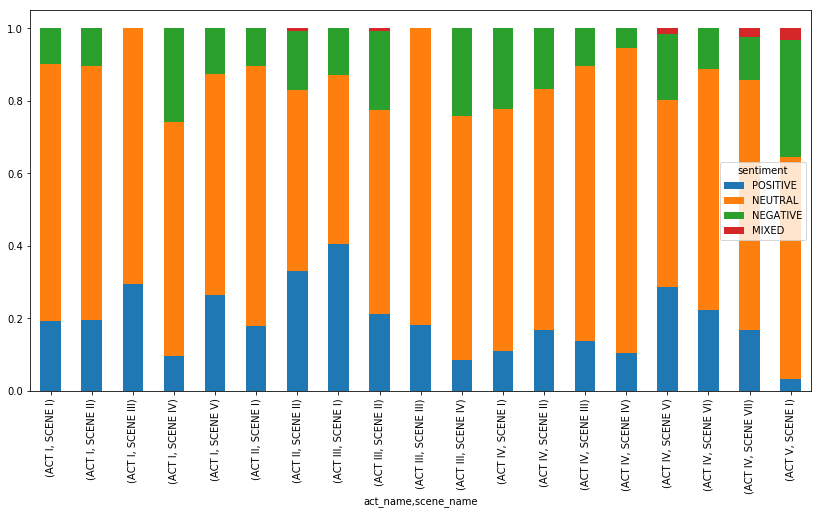

In [30]:
sentiment_dist_by_scene.plot.bar(stacked=True, figsize=(14,7))

# Comparison between Comprehend and TextBlob

textblob has two sentiment analyzers, the default one is pattern based, there's another Naive Bayes analyzer that was trained on movie review. I'll run both and compare. 

## Pattern analyzer

In [31]:
scene_paragraphs['sentiment_textblob'] = scene_paragraphs.paragraph_text.map(get_textblob_sentiment_pattern)

In [33]:
sentiment_by_scene_textblob_pat = scene_paragraphs\
                                .pivot_table(index=['act_name','scene_name'], 
                                             values='sentiment_textblob', 
                                             aggfunc='mean')

sentiment_by_scene_textblob_pat

sentiment_textblob
act_name scene_name                    
ACT I    SCENE I               0.091711
         SCENE II              0.105305
         SCENE III             0.076212
         SCENE IV             -0.048298
         SCENE V               0.069212
ACT II   SCENE I               0.093912
         SCENE II              0.150598
ACT III  SCENE I               0.233276
         SCENE II              0.113469
         SCENE III             0.138504
         SCENE IV             -0.028169
ACT IV   SCENE I               0.069635
         SCENE II              0.114884
         SCENE III             0.038636
         SCENE IV              0.043369
         SCENE V               0.100899
         SCENE VI              0.079563
         SCENE VII             0.066634
ACT V    SCENE I               0.104304

### Plot

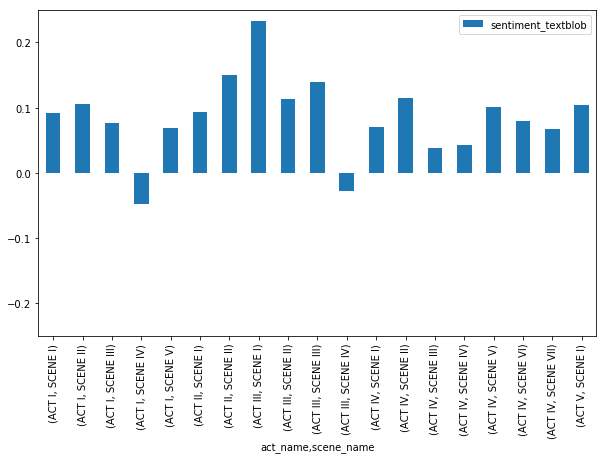

In [34]:
sentiment_by_scene_textblob_pat.plot.bar(figsize=(10,6), ylim=(-0.25,0.25))

### Comparison

It's hard to compare them fairly since textblob only produce a sentiment score on the positive/negative polarity, but when plotted together, we can see they largely agree, though the result on the very last scene seems to differ a lot. 

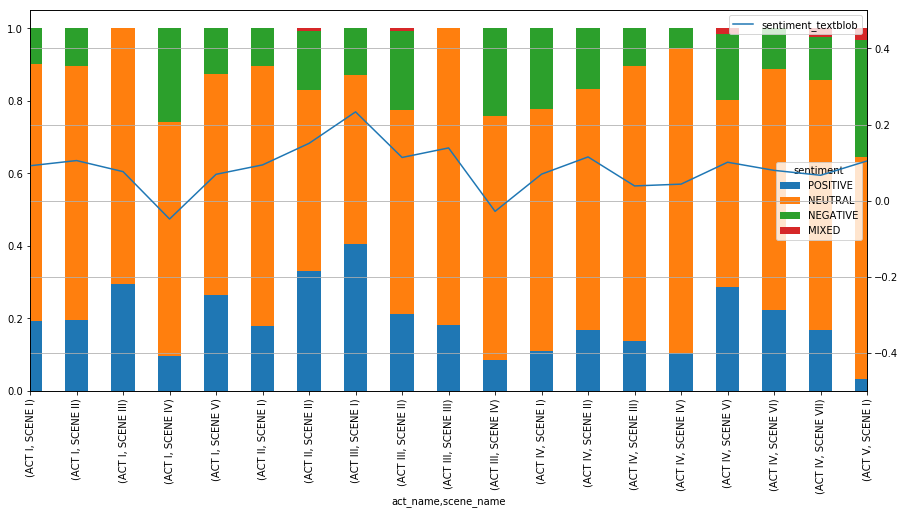

In [35]:
fig, ax1 = plt.subplots(figsize=(15,7))
ax2 = ax1.twinx()

sentiment_dist_by_scene.plot.bar(stacked=True, ax=ax1)
sentiment_by_scene_textblob_pat.plot(ax=ax2, ylim=(-0.5, 0.5), grid=True)

## Naive Bayes Analyzer

It's simply too slow. 4 seconds per paragraph is even much slower than the huge neural network NLP models. I don't see this level of performance do well on any use case except maybe in class room.

And it crashes my notebook kernal on a t2.medium EC2 instance when running against all 900+ paragraphs. 

In [44]:
%%time
scene_paragraphs.paragraph_text.sample(1, random_state=1).map(get_textblob_sentiment_naivebayes)

CPU times: user 4.16 s, sys: 128 ms, total: 4.28 s
Wall time: 4.28 s


242    pos
Name: paragraph_text, dtype: object

In [43]:
%%time
scene_paragraphs.paragraph_text.sample(10, random_state=1).map(get_textblob_sentiment_naivebayes)

CPU times: user 41.1 s, sys: 891 ms, total: 42 s
Wall time: 42 s


242    pos
841    pos
415    pos
731    pos
605    pos
310    pos
864    pos
791    pos
36     pos
79     pos
Name: paragraph_text, dtype: object